In [1]:
# this is where I am doing processing for one file
from IPython.core.display import Image
from sef_eeg_microstates import *
from preprocessing import read_sef
import time 

In [2]:
filename = "EO_CT001_20110526_1514_Stitch.sef"
chs, fs, data_raw = read_sef(filename)
# I need to drop the REF Channel since it does not correspond to the 213 channels 
data_raw = data_raw[:,:213]

[['version:' 'SE01']
 ['number of channels:' '214']
 ['number of aux channels:' '0']
 ['number of timeframes:' '241000']
 ['samplingrate:' '1000.0']
 ['year:' '2011']
 ['month:' '5']
 ['day:' '26']
 ['hour:' '15']
 ['minute:' '48']
 ['second:' '50']
 ['millisecond:' '890']]


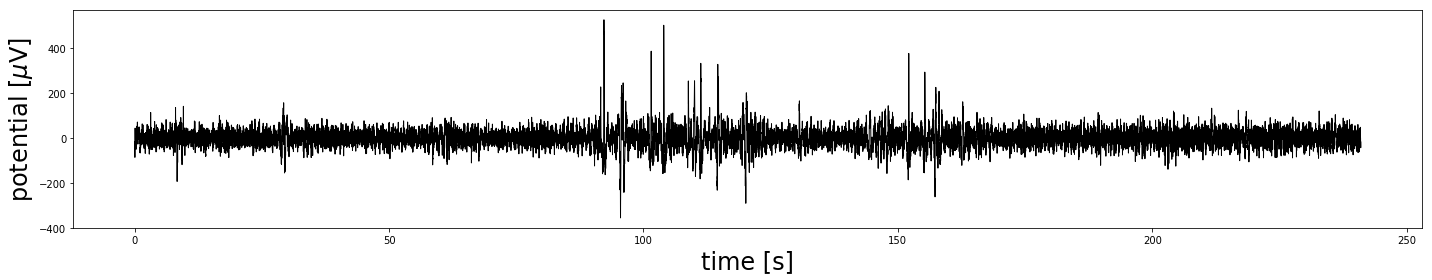

In [3]:
data = bp_filter(data_raw, (1,35), fs)
pca = PCA(copy=True, n_components=1, whiten=False)
pca1 = pca.fit_transform(data)[:,0]
plot_data(pca1, fs)

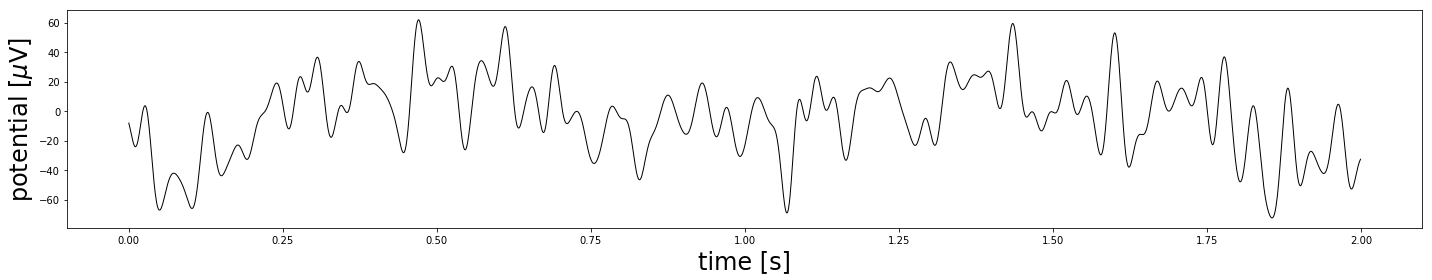

In [4]:
t0, t1 = 1000, 3000
plot_data(pca1[t0:t1], fs)

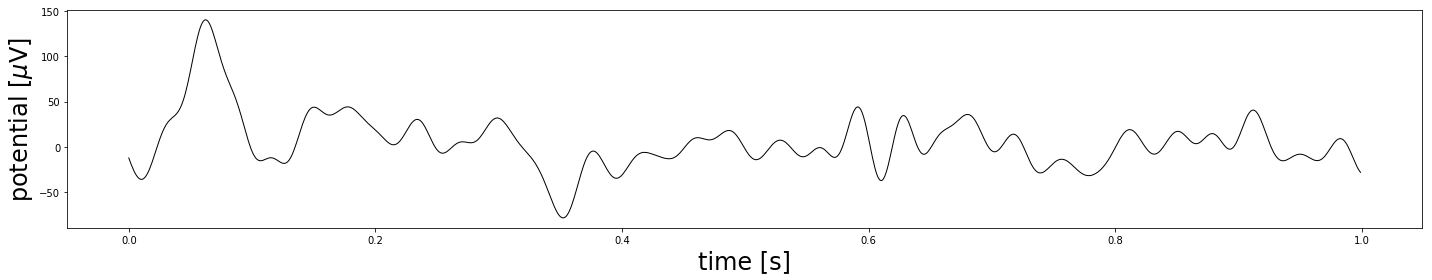

In [5]:
t0, t1 = 9500, 10500
plot_data(pca1[t0:t1], fs)

Clustering algorithm: kmeans
	[+] Data format for clustering [GFP peaks, channels]: 7349 x 213

	[+] Clustering algorithm: mod. K-MEANS.
The number of peaks: 7349
		K-means run 1/5 converged after 17 iterations.
		K-means run 2/5 converged after 21 iterations.
		K-means run 3/5 converged after 56 iterations.
		K-means run 4/5 converged after 31 iterations.
		K-means run 5/5 converged after 29 iterations.



(241000, 213)
(4, 213)



	[+] Computation time: 38.79

	[+] Global explained variance GEV = 0.700
		GEV_0: 0.106
		GEV_1: 0.312
		GEV_2: 0.148
		GEV_3: 0.135
shape of maps is: 
(4, 213)
1.495777435529463
(213,)
(213,)
(64,)
(64,)
(213,)
shape of maps is: 
(4, 213)
1.495777435529463
(213,)
(213,)
(64,)
(64,)
(213,)
shape of maps is: 
(4, 213)
1.495777435529463
(213,)
(213,)
(64,)
(64,)
(213,)
shape of maps is: 
(4, 213)
1.495777435529463
(213,)
(213,)
(64,)
(64,)
(213,)


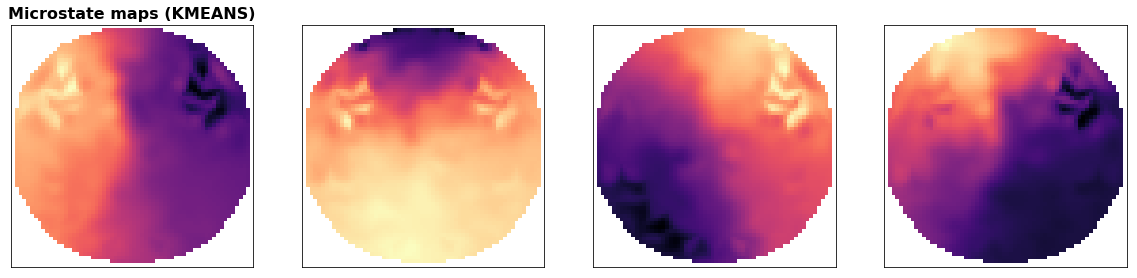


		Assign map labels (e.g. 0, 2, 1, 3): 0,1,2,3
		Re-ordered labels: 0, 1, 2, 3
1.495777435529463
(213,)
(213,)
(64,)
(64,)
(213,)
1.495777435529463
(213,)
(213,)
(64,)
(64,)
(213,)
1.495777435529463
(213,)
(213,)
(64,)
(64,)
(213,)
1.495777435529463
(213,)
(213,)
(64,)
(64,)
(213,)


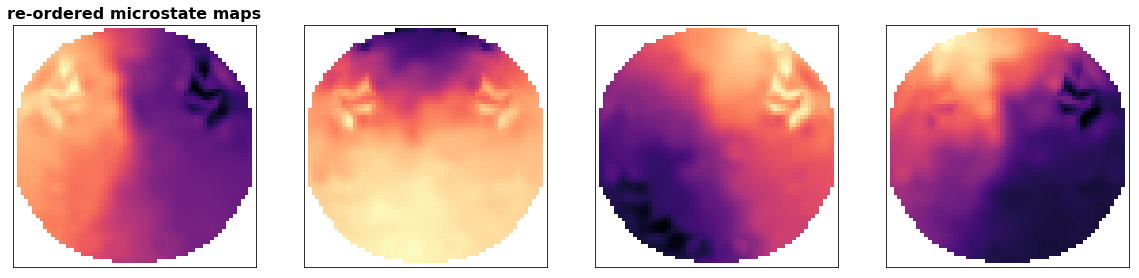

The length of the sequence: 241000


In [6]:
n_maps = 4 # the number of classes 
mode = ["aahc", "kmeans", "kmedoids", "pca", "ica"][1]
print("Clustering algorithm: {:s}".format(mode))
locs = []
maps, x, gfp_peaks, gev = clustering(data, fs, chs, locs, mode, n_maps, doplot=True)
print("The length of the sequence: {0}".format(len(x)))

In [7]:
# this is where we can start doing stuff with the microstates 
# like start to analyze which of the followin has which letters 
# and also add the libraries for the decision tree and stuff 
# get the number of 0, 1, 2, 3
from collections import Counter
counter = Counter(x)
print(counter)

Counter({1: 64464, 3: 60770, 0: 58633, 2: 57133})


In [8]:
# basic mircostate statistics 
p_hat = p_empirical(x, n_maps)
T_hat = T_empirical(x, n_maps)
print("\n\t\tEmpirical symbol distribution (RTT):\n")
for i in range(n_maps): print("\t\tp_{:d} = {:.3f}".format(i, p_hat[i]))
print("\n\t\tEmpirical transition matrix:\n")
print_matrix(T_hat)
pps = len(gfp_peaks) / (len(x)/fs)  # peaks per second
print("\n\t\tGFP peaks per sec.: {:.2f}".format(pps))
print("\n\t\tGlobal explained variance (GEV) per map:")
print "\t\t" + str(gev)
print("\n\t\ttotal GEV: {:.2f}".format(gev.sum()))


		Empirical symbol distribution (RTT):

		p_0 = 0.243
		p_1 = 0.267
		p_2 = 0.237
		p_3 = 0.252

		Empirical transition matrix:

		|0.912 0.007 0.040 0.040|
		|0.007 0.924 0.033 0.036|
		|0.040 0.038 0.914 0.008|
		|0.040 0.037 0.007 0.916|

		GFP peaks per sec.: 30.49

		Global explained variance (GEV) per map:
		[0.10589953 0.31212969 0.14775808 0.13458759]

		total GEV: 0.70


In [9]:
# okay I will just make the function myself for calculating the second order transition matrix 
def create_second_order_trans_matrix(sequence):
    # here we need to determine the number of classes 
    counter = Counter(sequence)
    num_classes = len(counter)
    # I will store it as a dictionary 
    # so I have <class1><class2> -> <class3>
    words = {}
    counter = 0
    # we need a two class scanner 
    for index in range(len(sequence)-2):
        key = "{0}+{1}".format(sequence[index], sequence[index+1])
        next_letter = sequence[index+2]
        # we need another dictionary in the dictionary 
        if key in words:
            if next_letter in words[key]:
                words[key][next_letter] += 1
            else:
                words[key][next_letter] = 1
                
        else:
            words[key] = {next_letter:1}
    # we divide by the number of possible transitions we
    for key in words:
        for letter in words[key]:
            words[key][letter] /= (len(sequence)-2.0)
    return words

second_order = create_second_order_trans_matrix(x)

# theses numbers are really small 
# let me sort the values 
number_to_sequence = []
for key in second_order:
    for letter in second_order[key]:
        number_to_sequence.append((second_order[key][letter], "{0}->{1}".format(key, letter)))
order_number_to_seq = sorted(number_to_sequence, reverse=True)

print("TOP TEN second order transition matrix:")
for i in range(10):
    print(order_number_to_seq[i])

TOP TEN second order transition matrix:
(0.22843758039485804, '1+1->1')
(0.21103494634810246, '3+3->3')
(0.2022008481398186, '0+0->0')
(0.1975991502004166, '2+2->2')
(0.00946895824861617, '3+3->0')
(0.00931128059154018, '3+0->0')
(0.00921584411488892, '0+2->2')
(0.009145304110407555, '0+3->3')
(0.00914115469837924, '0+0->3')
(0.009120407638237661, '0+0->2')


In [10]:
# I am testing how I can even figure out where to segment the data 
# reimport since I am modifying the functions 
from sef_eeg_microstates import *

def test(data, fs, chs, locs, mode, n_maps):
    maps, x, gfp_peaks, gev = clustering(data, fs, chs, locs, mode, n_maps, doplot=False)

test(data, fs, chs, locs, mode, n_maps)


	[+] Data format for clustering [GFP peaks, channels]: 7349 x 213

	[+] Clustering algorithm: mod. K-MEANS.
The number of peaks: 7349
		K-means run 1/5 converged after 17 iterations.
		K-means run 2/5 converged after 34 iterations.


sef_eeg_microstates.py:615: ComplexWarning: Casting complex values to real discards the imaginary part
  maps[k, :] = v/np.sqrt(np.sum(v**2))


		K-means run 3/5 converged after 42 iterations.
		K-means run 4/5 converged after 53 iterations.
		K-means run 5/5 converged after 34 iterations.



(241000, 213)
(4, 213)



	[+] Computation time: 40.29

	[+] Global explained variance GEV = 0.700
		GEV_0: 0.106
		GEV_1: 0.135
		GEV_2: 0.312
		GEV_3: 0.148


In [18]:
# so here I make a plot with sliding window ten 
window = 20


def sliding_window(sequence, n_maps, window):
    
    letters_in_window = [{i:0 for i in range(n_maps)} for x in range(window)]
    for i in range(len(sequence)/window):
        part = sequence[i*window:i*window+window]
        for index,x in enumerate(part):
            letters_in_window[index][x] += 1
            
    print "length of sequence: " + str(len(sequence))
    print "what was read: " + str(i*window+window) 
    # I am just skipping the remainder at this point 
    
    return letters_in_window

test = sliding_window(x, n_maps, window)

length of sequence: 241000
what was read: 241000


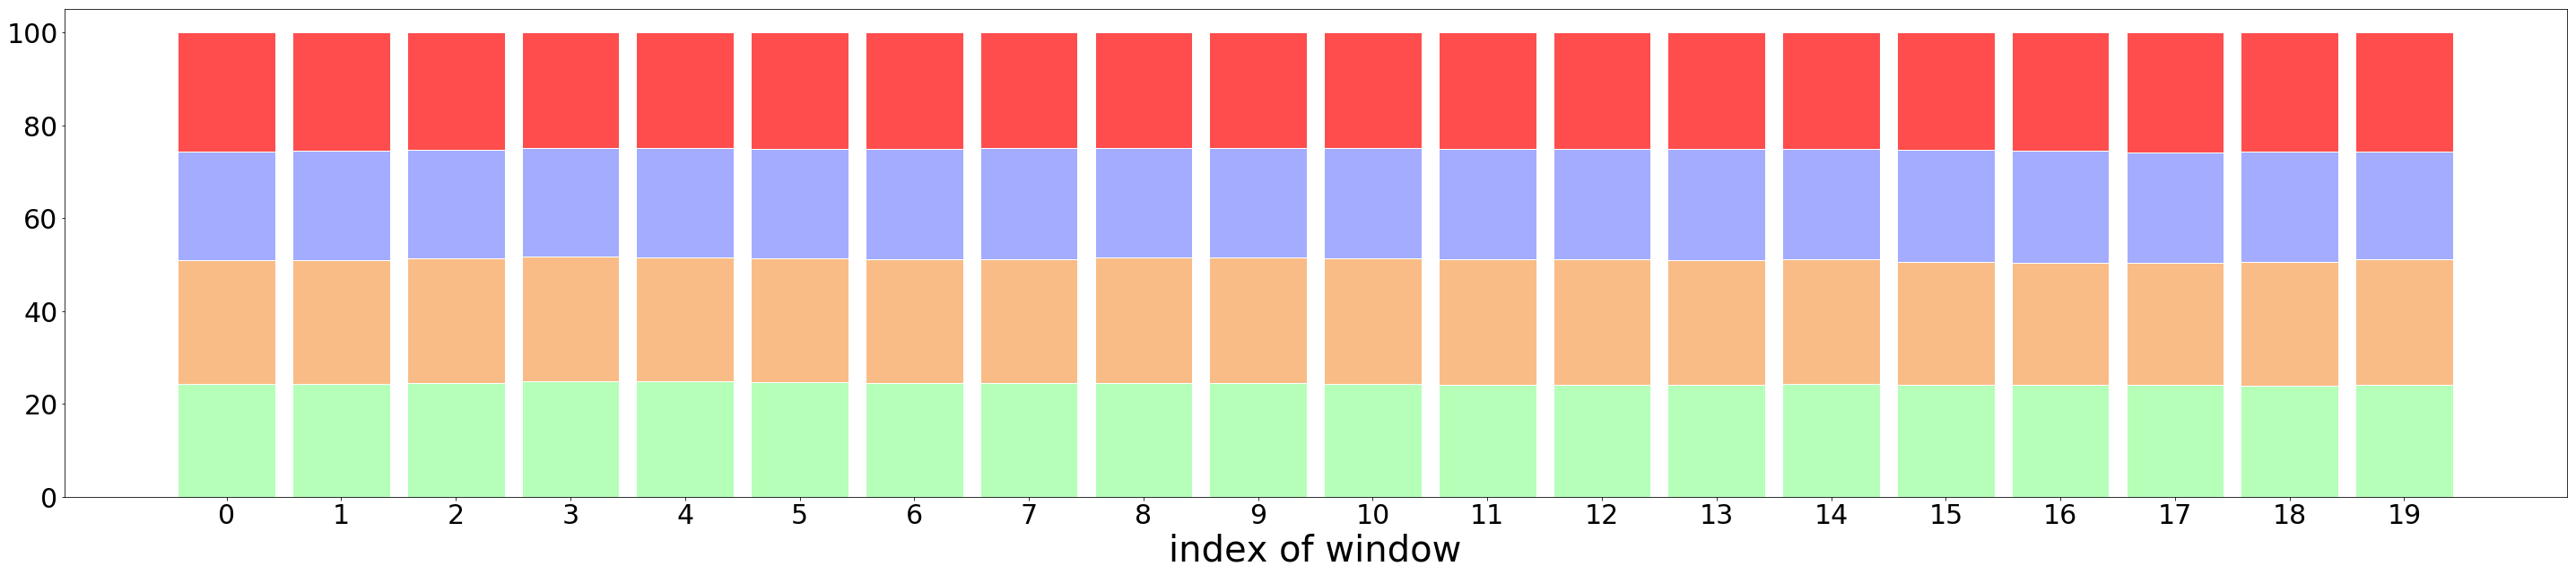

In [19]:
# libraries
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import rc
import pandas as pd

# Data
r = [i for i in range(window)]
raw_data = {'greenBars' : [test[i][0] for i in range(window)], 
            'orangeBars': [test[i][1] for i in range(window)],
            'blueBars'  : [test[i][2] for i in range(window)],
            'redBars'   : [test[i][3] for i in range(window)]}
df = pd.DataFrame(raw_data)

#print df

# From raw value to percentage
totals = [i+j+k+l for i,j,k,l in zip(df['greenBars'], df['orangeBars'], df['blueBars'], df['redBars'])]
greenBars = [i*1.0 / j * 100 for i,j in zip(df['greenBars'], totals)]
orangeBars = [i*1.0 / j * 100 for i,j in zip(df['orangeBars'], totals)]
blueBars = [i*1.0 / j * 100 for i,j in zip(df['blueBars'], totals)]
redBars = [i*1.0 / j * 100 for i,j in zip(df['redBars'], totals)]

# plot
barWidth = 0.85
names = [str(i) for i in range(window)]
# Create green Bars
plt.bar(r, greenBars, color='#b5ffb9', edgecolor='white', width=barWidth)
# Create orange Bars
plt.bar(r, orangeBars, bottom=greenBars, color='#f9bc86', edgecolor='white', width=barWidth)
# Create blue Bars
plt.bar(r, blueBars, bottom=[i+j for i,j in zip(greenBars, orangeBars)], color='#a3acff', edgecolor='white', 
        width=barWidth)
# Create Red Bars
plt.bar(r, redBars, bottom=[i+j+k for i,j,k in zip(greenBars,orangeBars,blueBars)], color='#ff4d4d', 
        edgecolor='white', width=barWidth)


# make figure larger
plt.rcParams['figure.figsize'] = [50, 10]

# Custom x axis
plt.xticks(r, names, fontsize=30)
plt.yticks(fontsize=30)
plt.xlabel("index of window", fontsize=40)
 
# Show graphic
plt.show()

In [13]:
# determine the length of streches of 0,1,2,3
# find the max lenghts 
def continual_length(sequence, value):
    lengths = []
    length = 0
    i = 0
    while i < len(sequence):
        if sequence[i] == value:
            length += 1
        else:
            if length > 0:
                lengths.append((length, i))
                length = 0
        i += 1
    return lengths

continual_zero = continual_length(x, 0)
# I can sort these balues but I should maybe start highlighting where they are 
top_ten = sorted(continual_zero, reverse=True)[:10]
print top_ten

# plot the bands on the x axis 
# time to get all four 
repeating_blocks = {}
for i in range(n_maps):
    repeating_blocks[i] = continual_length(x, i)

[(128, 65677), (106, 148965), (106, 94657), (88, 10221), (87, 47801), (84, 142073), (82, 212453), (81, 141443), (81, 66875), (77, 38086)]


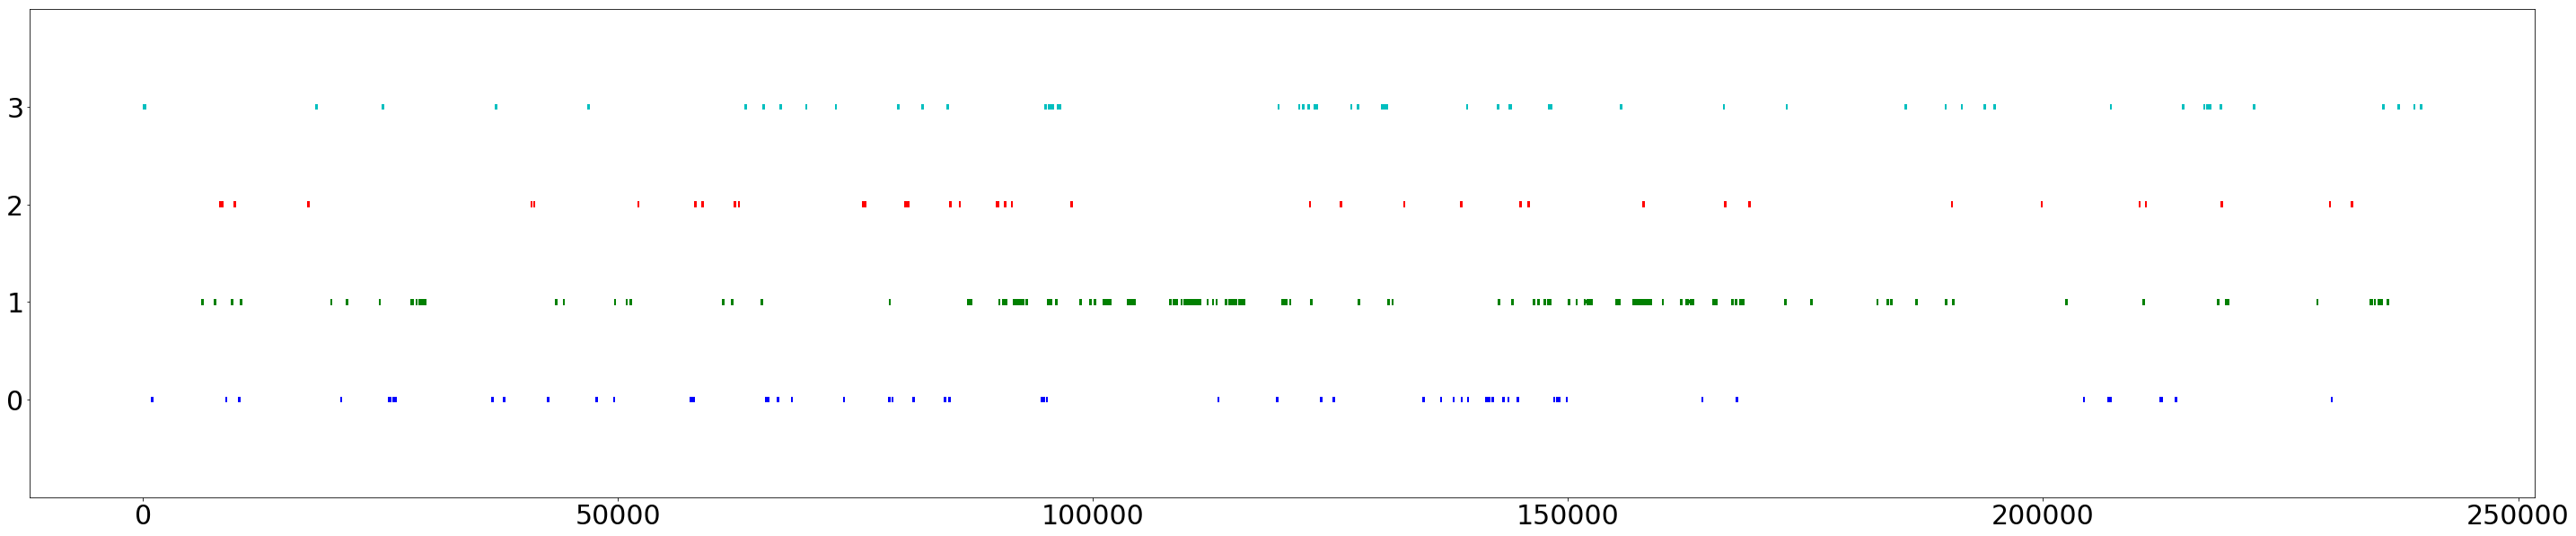

In [14]:
# we need to filter the segments which are too short to concern us 
# we can also subset it to certain ranges of interest 

repeat_blocks_start_end = {}

for i in range(n_maps):
    start = []
    stop = []

    for length, index in repeating_blocks[i]:
        if length >= 50:
            start.append(index-length)
            stop.append(index)
    repeat_blocks_start_end[i] = {'start': start, 'stop':stop}
    
ax = plt.gca()

def plot_line(y, xstart, xstop, color='b'):
    plt.hlines(y, xstart, xstop, color, lw=4)
    plt.vlines(xstart, y+0.03, y-0.03, color, lw=2)
    plt.vlines(xstop, y+0.03, y-0.03, color, lw=2)
    
    
colors = ['b', 'g', 'r', 'c']
# so now let us do that for all of the parts 
for n_class in range(n_maps):
    for i in range(len(repeat_blocks_start_end[n_class]['start'])):
        plot_line(n_class, repeat_blocks_start_end[n_class]['start'][i], 
                  repeat_blocks_start_end[n_class]['stop'][i], colors[n_class])

plt.ylim(-1,4)
plt.yticks([i for i in range(n_maps)], [str(i) for i in range(n_maps)])
plt.xticks(fontsize=30)
plt.yticks(fontsize=30)
plt.show()

total number of repeats: 239580
1.0
TOP 10 second order transition matrix:
(0.08815232722143865, '3+0->2')
(0.08533145275035262, '1+2->0')
(0.08392101551480959, '2+1->3')
(0.08251057827926657, '3+1->2')
(0.07968970380818054, '0+2->1')
(0.07827926657263752, '2+0->3')
(0.07334273624823695, '0+3->1')
(0.056417489421720736, '1+3->0')
(0.03455571227080395, '2+3->0')
(0.03244005641748942, '0+3->2')


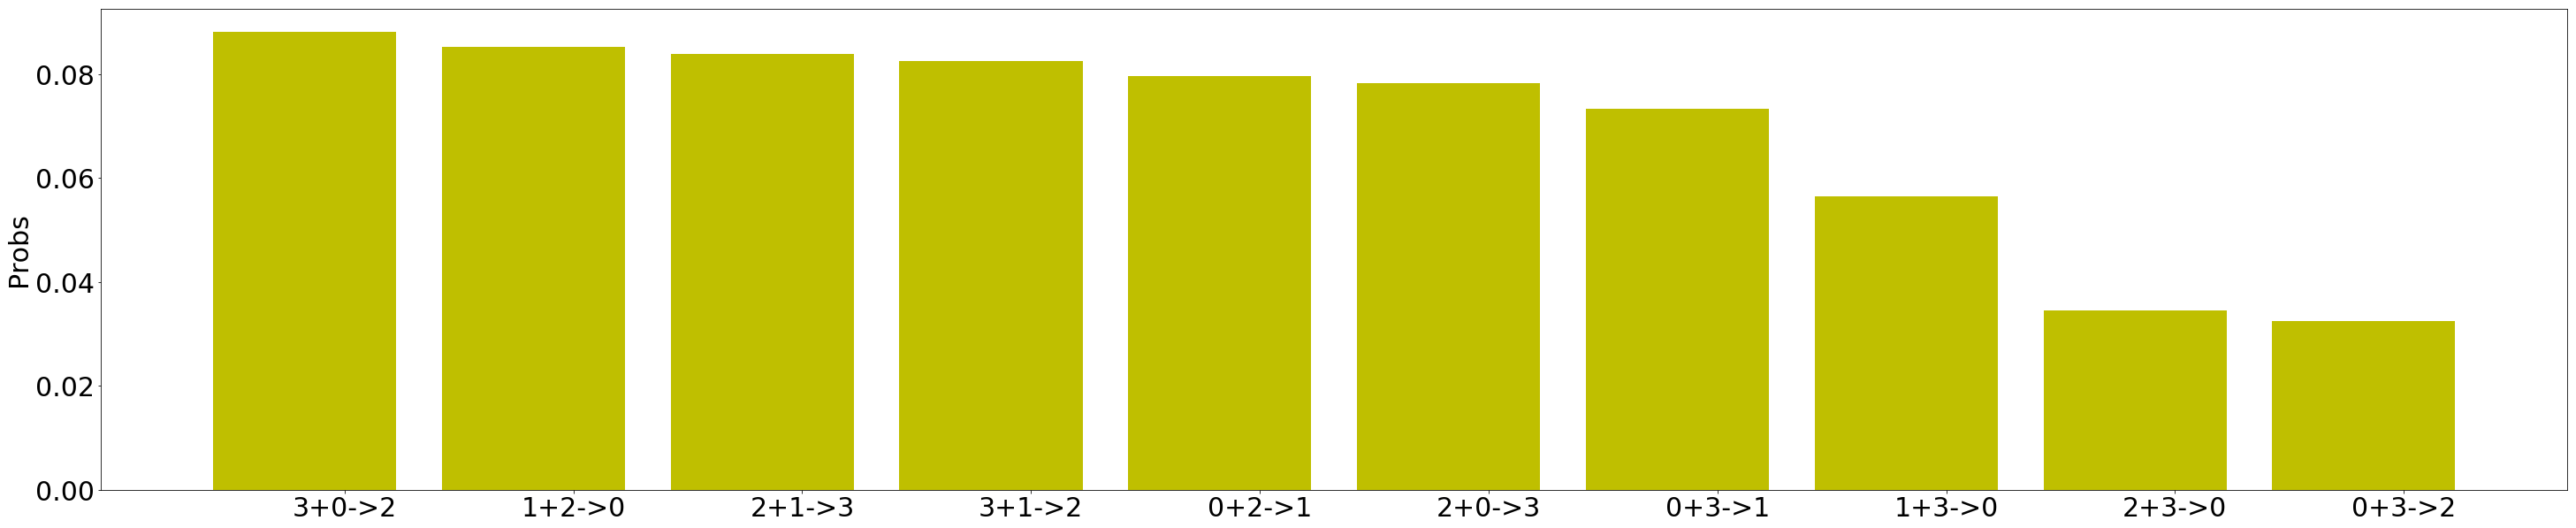

In [15]:
# make another plot for transition to <class1> -> <class2>
# this is kind of first order markov property but we can increase it to maybe three or four 
# now we will analyze the sequence
# okay I will just make the function myself for calculating the second order transition matrix 
def create_second_order_trans_matrix_ignore_repeat(sequence):
    # here we need to determine the number of classes 
    counter = Counter(sequence)
    num_classes = len(counter)
    # I will store it as a dictionary 
    # so I have <class1><class2> -> <class3>
    words = {}
    counter = 0
    # we need a two class scanner 
    for index in range(len(sequence)-2):
        key = "{0}+{1}".format(sequence[index], sequence[index+1])
        next_letter = sequence[index+2]
        # we need another dictionary in the dictionary 
        if key in words:
            if next_letter in words[key]:
                words[key][next_letter] += 1
            else:
                words[key][next_letter] = 1
                
        else:
            words[key] = {next_letter:1}
    # we divide by the number of possible transitions we
    # so we have the repeat calculated for 
    total_repeat = 0
    for letter in range(num_classes):
        for letter2 in range(num_classes):
            # also have to get rid of the double repeat in the back and in the front
            if letter != letter2:
                total_repeat += words["{0}+{1}".format(letter2, letter)][letter]
                del words["{0}+{1}".format(letter2, letter)][letter]

                total_repeat += words["{0}+{1}".format(letter, letter)][letter2]
                del words["{0}+{1}".format(letter, letter)][letter2]
        # if all three letters match 
        total_repeat += words["{0}+{1}".format(letter, letter)][letter]
        del words["{0}+{1}".format(letter, letter)][letter]
                
        
    print "total number of repeats: " + str(total_repeat)
    
    for key in words:
        for letter in words[key]:
            words[key][letter] /= (len(sequence)-total_repeat-2.0)
    return words

second_order_wo_repeat = create_second_order_trans_matrix_ignore_repeat(x)
# print second_order_wo_repeat
total = 0
for key in second_order_wo_repeat:
    for letter in second_order_wo_repeat[key]:
        total += second_order_wo_repeat[key][letter]
print total

# now I want to rankd them in order 
# theses numbers are really small 
# let me sort the values 
number_to_sequence_wo = []
for key in second_order:
    for letter in second_order_wo_repeat[key]:
        number_to_sequence_wo.append((second_order_wo_repeat[key][letter], "{0}->{1}".format(key, letter)))
        
order_number_to_seq_wo = sorted(number_to_sequence_wo, reverse=True)

N = 10
print("TOP {0} second order transition matrix:".format(N))
for i in range(N):
    print(order_number_to_seq_wo[i])


unzipped = zip(*order_number_to_seq_wo)
data, labels = unzipped
    
ind = np.arange(N)  # the x locations for the groups
width = 0.35       # the width of the bars

# now I have a bargraph to see how different certain are to each ither 
fig, ax = plt.subplots()
rects = ax.bar(ind, data[:N],color='y')


# add some text for labels, title and axes ticks
ax.set_ylabel('Probs',fontsize=30)
ax.set_xticks(ind + width / 2)
ax.set_xticklabels(labels[:N], fontsize=30)
plt.yticks(fontsize=30)
#plt.ylim(0,)
plt.show()